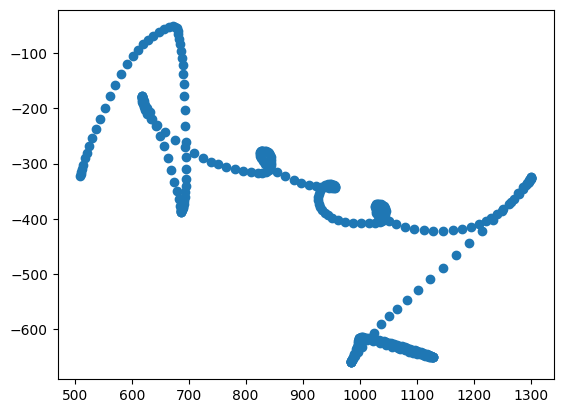

In [1]:
import numpy as np
import json

from plotting import plot_signals

from preprocess import preprocess

with open("data/signatures.txt") as f:
	signatures = json.load(f)
	np_signatures = np.array(signatures)

signals = [preprocess(np_signature) for np_signature in np_signatures]
plot_signals(signals)

signal = signals[0]

In [2]:
# !pip install --upgrade scipy==1.8.0
import scipy
print(scipy.__version__) # 1.8.0

1.8.0


In [3]:
print(len(signal.position),len(signal.velocity))

330 329


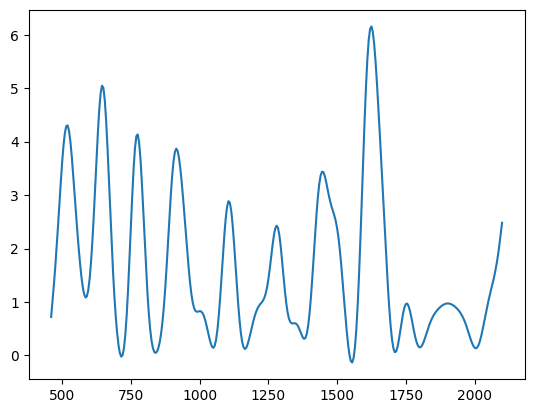

In [4]:
import matplotlib.pyplot as plt

plt.plot(signal.time[:-1],signal.speed)

['Point(role=2,idx=5,time=485.0,speed=2.4178092629565575,angle=5.029705699827004)', 'Point(role=3,idx=12,time=520.0,speed=4.303226723319164,angle=5.18903250005721)']
['Point(role=1,idx=0,time=460.0,speed=0.7180295750376625,angle=3.072919332717859)', 'Point(role=2,idx=5,time=485.0,speed=2.4178092629565575,angle=5.029705699827004)', 'Point(role=3,idx=12,time=520.0,speed=4.303226723319164,angle=5.18903250005721)', 'Point(role=4,idx=17,time=545.0,speed=3.0418514569439017,angle=5.37399051818184)', 'Point(role=5,idx=25,time=585.0,speed=1.0833692013285348,angle=7.005233558991916)']
LognormalStroke(D=383.0423043497579,t_0=273.305528208328,mu=5.528454926387512,sigma=0.1424931988919755,theta_s=4.941513064172169,theta_f=5.473958698521444)


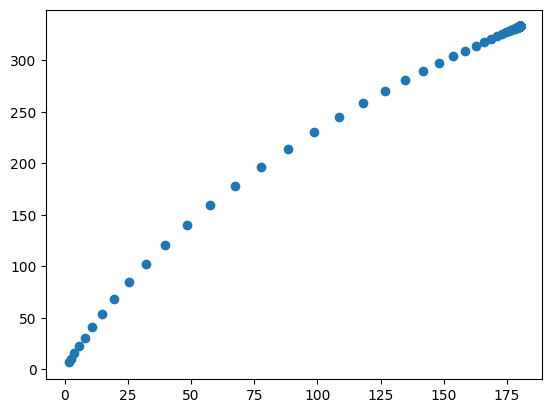

In [5]:
from speed_extract import extract_sigma_lognormal, get_point_combos, get_stroke_combos, mark_stroke_candidates

candidates=mark_stroke_candidates(signal)

candidate=candidates[0]
point_combos=get_point_combos(candidate)
point_combo = point_combos[0]
print([str(pt) for pt in point_combo])

stroke_combos = get_stroke_combos(candidate)
stroke_combo = stroke_combos[0]
print([str(pt) for pt in stroke_combo])

lognormal = extract_sigma_lognormal(point_combo,stroke_combo)
print(lognormal)
plot_signals([lognormal.signal(signal.time)])

In [6]:
np.array(1)/0

inf

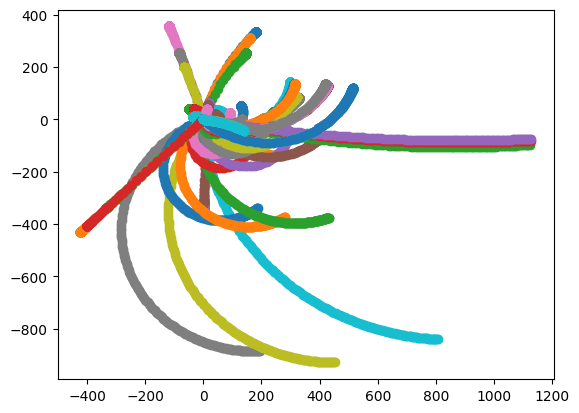

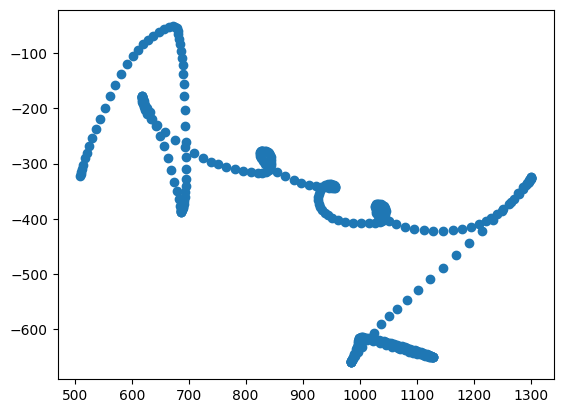

In [7]:
from speed_extract import extract_all_lognormals


lognormals = extract_all_lognormals(signal)

plot_signals([lgn.signal(signal.time) for lgn in lognormals])
plot_signals([signal])

In [8]:
from beam_search import BeamSearch
from action_plan import ActionPlan

top_k = 2
snr_threshold = 25 # I have no idea what to say for this.
max_strokes = 14
search = BeamSearch(signal,top_k,snr_threshold,max_strokes)

demo_plan = ActionPlan([],signal.position[0])

suggest_plans = search.get_next_action_plans([demo_plan])


Plan making 2411 plans - 0.5909411907196045
Sorting - 4.129247665405273


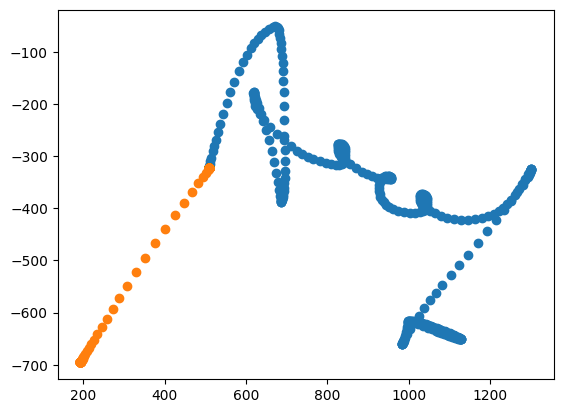

In [9]:
suggest_plan = suggest_plans[0]
plot_signals([signal,suggest_plan.signal(signal.time)])

In [10]:
out_plan = search.search()

Start iter - 0.0
Plan making 2411 plans - 0.628962516784668
Sorting - 4.359900712966919
Got children plans - 4.989928245544434
Max. SNR: 1.2024759448555327
Num. strokes: 1
Stop check - 0.0009572505950927734
Start iter - 0.0010001659393310547
Plan making 4143 plans - 0.9743063449859619
Sorting - 10.381010293960571
Got children plans - 11.356318235397339
Max. SNR: 2.013282606321064
Num. strokes: 2
Stop check - 0.0
Start iter - 0.0010035037994384766
Plan making 3888 plans - 0.8845610618591309
Sorting - 13.031097173690796
Got children plans - 13.915658235549927
Max. SNR: 2.9919992808357
Num. strokes: 3
Stop check - 0.0
Start iter - 0.0019931793212890625
Plan making 3972 plans - 0.8586015701293945
Sorting - 15.267637729644775
Got children plans - 16.12623929977417
Max. SNR: 3.8681416046232293
Num. strokes: 4
Stop check - 0.0
Start iter - 0.0019991397857666016
Plan making 3946 plans - 0.9513030052185059


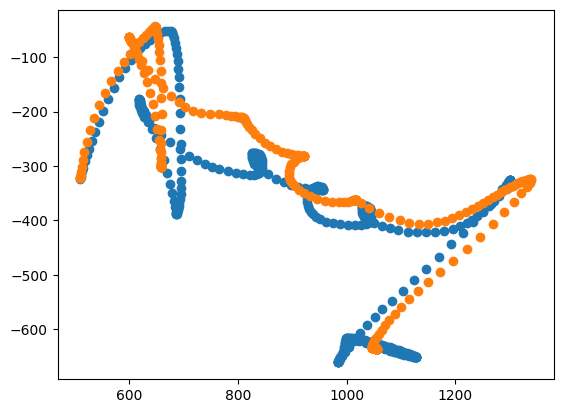

In [ ]:
plot_signals([signal,out_plan.signal(signal.time)])